In [ ]:
# Cloned from http://localhost:8815/notebooks/uwsgi/dotmaptiles/data-visualization-tools/examples/lodes/Interpolate%20from%20Allegheny%20County%20Magesterial%20Districts%20to%202010%20Census%20Blocks.ipynb
# copied from Randy's laptop on 10/2/18 to work on eviction data from Jeff Benzing at Public Source

In [1]:
# Boilerplate from Randy cheatsheet at https://docs.google.com/document/d/1utZuLHcKQEZNXTQLOysTNCxTHrqxczAUymmtplpn27Q/edit#
import pandas as pd
import geopandas as gpd
import numpy as np
from geopandas import GeoSeries, GeoDataFrame
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [2]:
# Wide display
from IPython.core.display import display, HTML
display(HTML("<style>#notebook-container { margin-left:-14px; width:calc(100% + 27px) !important; }</style>"))

In [3]:
import csv, json, os, numbers, pandas, re, scipy, scipy.sparse, shutil, StringIO
from matplotlib import pyplot
import subprocess, sys, threading, time, urllib2

def exec_ipynb(filename_or_url):
    nb = (urllib2.urlopen(filename_or_url) if re.match(r'https?:', filename_or_url) else open(filename_or_url)).read()
    jsonNb = json.loads(nb)
    #check for the modified formatting of Jupyter Notebook v4
    if(jsonNb['nbformat'] == 4):
        exec '\n'.join([''.join(cell['source']) for cell in jsonNb['cells'] if cell['cell_type'] == 'code']) in globals()
    else:
        exec '\n'.join([''.join(cell['input']) for cell in jsonNb['worksheets'][0]['cells'] if cell['cell_type'] == 'code']) in globals()

exec_ipynb('timelapse-utilities.ipynb')

In [4]:
import geopandas

#!conda install -y fiona geos psycopg2 pysal shapely 
#!conda install -y -c conda-forge geopandas

In [5]:
pandas.options.display.max_colwidth = 300

In [31]:
download_file('https://data.cmucreatelab.org/earthtime/us/districts_and_zips.geojson', 'data/districts_and_zips.geojson')

distzips = geopandas.GeoDataFrame.from_file('data/districts_and_zips.geojson')

distzips = distzips.to_crs(epsg=4326)

data/districts_and_zips.geojson already downloaded


In [84]:
distzips['distzip'] = [distzip['ZIP'] + 'MDJ-' + distzip['Magisteria'].split()[-1]  for index, distzip in distzips.iterrows()]

In [85]:
distzips

,Magisteria,ZIP,geometry,distzip
index_left,,,,
0,Magisterial District 05-3-02,15003,"(POLYGON ((-80.22363440639117 40.57592713797421, -80.2237760579409 40.57618674271584, -80.2237717099128 40.5761805327918, -80.2236339901756 40.5759281338432, -80.22363440639117 40.57592713797421)), POLYGON ((-80.22388552609208 40.57634308689938, -80.22394423489325 40.57642380334688, -80.22394601...",15003MDJ-05-3-02
1,Magisterial District 05-2-12,15005,"POLYGON ((-80.148476234629 40.67376851060921, -80.13186195080054 40.67363602630036, -80.13186194752785 40.67363602627427, -80.1328899456376 40.6723572584818, -80.132777305454 40.671087844565, -80.1328035734991 40.6710869967893, -80.1331187257055 40.6710757152425, -80.1331313629191 40.67107614202...",15005MDJ-05-2-12
2,Magisterial District 05-3-02,15005,"POLYGON ((-80.14330315598292 40.61478924223093, -80.13946710899448 40.61487033056763, -80.13952614263951 40.6148674943725, -80.13964055958979 40.6148619973917, -80.13999758993241 40.6148448442552, -80.14009167989001 40.6148403237617, -80.1407068265232 40.6148107697937, -80.1408078317349 40.61480...",15005MDJ-05-3-02
3,Magisterial District 05-3-04,15006,"POLYGON ((-79.87947895502103 40.6290363675701, -79.87947897512529 40.629036361273, -79.87957326397427 40.62938828195507, -79.8796837836414 40.6298007820234, -79.8800667879614 40.6301310278515, -79.88119593357531 40.62966993964754, -79.8811959560487 40.6296699304705, -79.88162546696046 40.6310581...",15006MDJ-05-3-04
4,Magisterial District 05-3-04,15007,"POLYGON ((-79.92363391662251 40.6538555945779, -79.923916819783 40.6538471721299, -79.9242524686309 40.6538376217109, -79.92424780153125 40.65352898963616, -79.9242380734336 40.6528845756664, -79.92422972190872 40.652331526374, -79.92421736025779 40.65188961352775, -79.9242150586999 40.651807183...",15007MDJ-05-3-04
5,Magisterial District 05-2-05,15014,"POLYGON ((-79.73987943552282 40.60108917548789, -79.74113573232739 40.6008013624821, -79.74120420449074 40.60078564431359, -79.74124668117869 40.6007759120037, -79.7427689618391 40.6020610738989, -79.7429015586295 40.6021777314114, -79.7433653486913 40.6025857656749, -79.7435203134927 40.6027157...",15014MDJ-05-2-05
6,Magisterial District 05-2-12,15015,"POLYGON ((-80.07129983859888 40.64435216028103, -80.0709037289932 40.6441767252367, -80.07090080326319 40.64411224938414, -80.0708981269869 40.6440530037233, -80.07089429850721 40.64396824662372, -80.07110044600419 40.6439628152273, -80.07130495208852 40.64396266807374, -80.0717665080394 40.6439...",15015MDJ-05-2-12
7,Magisterial District 05-2-20,15017,"(POLYGON ((-80.11634588227032 40.31268862395832, -80.11648335603002 40.31290288392824, -80.11654409592057 40.31304849346824, -80.11663989015661 40.31329580753182, -80.11671153525107 40.31348925594905, -80.11672804206201 40.3137095140496, -80.1167103102723 40.31390225044104, -80.11663957371763 40...",15017MDJ-05-2-20
8,Magisterial District 05-2-21,15017,"POLYGON ((-80.17086683336422 40.32903927497458, -80.17082247650571 40.3290687643806, -80.17078997087701 40.32909236831407, -80.1707483381208 40.3291225999031, -80.17059557553571 40.3292335260402, -80.17035203417572 40.3294035419584, -80.17027500259719 40.32946477629442, -80.1701598255879 40.3295...",15017MDJ-05-2-21


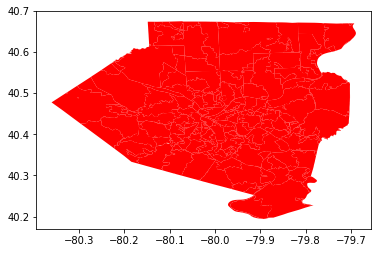

In [134]:
f, ax = pyplot.subplots(1)
# Plot polygons in light grey
distzips.plot(ax=ax, figsize=(40,40),color='red',linewidth=400)
# Overlay railway tunnels on top in strong green
distzips.loc[distzips['distzip']=='15005MDJ-05-3-02'].plot(figsize=(40,40),ax=ax,color='green',linewidth=40)
pyplot.show()

In [26]:
blocks = geopandas.GeoDataFrame.from_file('data/tl_2010_42003_tabblock10/tl_2010_42003_tabblock10.shp')

In [27]:
blocks = blocks.to_crs(epsg=4326)

In [36]:
blocks['geometry'] = blocks['geometry'].centroid

In [86]:
distzip_blocks = geopandas.sjoin(distzips, blocks, how="inner", op='intersects')

In [41]:
rentals = numpy.load('data/census2010_block2010.H0040004.numpy')
print 'rentals has', rentals.sum(), 'total units'

rentals has 40730218 total units


In [45]:
block_geoids_2010 = json.load(open('data/block_geoids_2010.json'))
print 'There are', len(block_geoids_2010), 'blocks'

assert(len(block_geoids_2010) + 1 == len(rentals))

There are 11078297 blocks


In [49]:
block_geoids_2010.index('420034470001027')

8120744

## Read eviction data from google sheet

In [76]:
csv_body = urllib2.urlopen('https://docs.google.com/spreadsheets/d/e/2PACX-1vSmDMACCNS_-2l6y04JkOnMd7RhCYpC6bzzGurXWAh-UMgtqG2EqW38w7bvzXt6fiOJnhpTNy15zl5q/pub?output=csv').read()

In [80]:
evictions = pandas.read_csv(StringIO.StringIO(csv_body))

In [102]:
evictions['distzip'] = evictions['Unnamed: 0']
evictions.head()

,Unnamed: 0,2008,2009,2010,2011,2012,2013,2014,2015,2016,distzip
0,15003MDJ-05-3-02,2,13,23,0,21,6,10,10,11,15003MDJ-05-3-02
1,15005MDJ-05-2-12,3,0,0,1,0,0,0,0,0,15005MDJ-05-2-12
2,15005MDJ-05-3-02,0,0,2,0,20,0,0,0,0,15005MDJ-05-3-02
3,15006MDJ-05-3-04,0,1,0,0,0,0,0,2,0,15006MDJ-05-3-04
4,15007MDJ-05-3-04,0,0,0,0,0,0,2,2,0,15007MDJ-05-3-04


## Interpolate from distzips to blocks

In [95]:
geoid10_to_index = {}
for i, geoid10 in enumerate(block_geoids_2010):
    geoid10_to_index[geoid10] = i + 1

In [135]:
type(rentals)

numpy.ndarray

In [152]:
for year in range(2008, 2017):
    block_evictions = numpy.zeros(len(block_geoids_2010), dtype=numpy.float32)
    all_eviction_count = 0
    uncounted_evictions = 0
    for index, distzip in distzips.iterrows():
        distzip_id = distzip['distzip']
        eviction_count = evictions.loc[evictions['distzip'] == distzip_id][str(year)].values
        if len(eviction_count) == 0:
            continue
        eviction_count = eviction_count[0]
        # Sum rental count across blocks
        rental_count = 0
        block_count = 0
        for index, distzip_block in distzip_blocks.loc[distzip_blocks['distzip'] == distzip_id].iterrows():
            block_count += 1
            rental_count += rentals[geoid10_to_index[distzip_block['GEOID10']]]

        if rental_count:
            # Interpolate evictions count across blocks
            for index, distzip_block in distzip_blocks.loc[distzip_blocks['distzip'] == distzip_id].iterrows():
                evictions_in_block = eviction_count * rentals[geoid10_to_index[distzip_block['GEOID10']]] / float(rental_count)
                block_evictions[geoid10_to_index[distzip_block['GEOID10']]] = evictions_in_block
        else:
            uncounted_evictions += eviction_count

        all_eviction_count += eviction_count
        #print '%4d %5d %4d %s' % (eviction_count, rental_count, block_count, distzip_id)

    dest = 'evictions-%d.float32' % year
    open(dest, 'w').write(block_evictions.tobytes())
    print 'Created %s' % dest
    print year, all_eviction_count, uncounted_evictions, block_evictions.sum()

Created evictions-2008.float32
2008 21091 568 20523.0
Created evictions-2009.float32
2009 28330 650 27680.0
Created evictions-2010.float32
2010 30255 635 29620.0
Created evictions-2011.float32
2011 30825 639 30186.0
Created evictions-2012.float32
2012 38696 162 38534.0
Created evictions-2013.float32
2013 40121 142 39979.0
Created evictions-2014.float32
2014 39584 151 39433.0
Created evictions-2015.float32
2015 38208 245 37963.0
Created evictions-2016.float32
2016 38127 100 38027.0


In [153]:
!ls -l evictions*float32

-rw-r--r--  1 rsargent  staff  44313188 Nov 18 13:36 evictions-2008.float32
-rw-r--r--  1 rsargent  staff  44313188 Nov 18 13:36 evictions-2009.float32
-rw-r--r--  1 rsargent  staff  44313188 Nov 18 13:36 evictions-2010.float32
-rw-r--r--  1 rsargent  staff  44313188 Nov 18 13:36 evictions-2011.float32
-rw-r--r--  1 rsargent  staff  44313188 Nov 18 13:36 evictions-2012.float32
-rw-r--r--  1 rsargent  staff  44313188 Nov 18 13:36 evictions-2013.float32
-rw-r--r--  1 rsargent  staff  44313188 Nov 18 13:37 evictions-2014.float32
-rw-r--r--  1 rsargent  staff  44313188 Nov 18 13:37 evictions-2015.float32
-rw-r--r--  1 rsargent  staff  44313188 Nov 18 13:37 evictions-2016.float32


In [154]:
!pwd

/Users/rsargent/projects/evictions


In [ ]:
# rsync -av /Users/rsargent/projects/evictions/evictions-*.float32 hal15:/home/rsargent/uwsgi/dotmaptiles/server/columncache/pa_allegheny_county_evictions

In [ ]:
    output_cols = {}
    missing_tracts = {}
    for state in state_names:
        data = read_acs2015_year_data(state, seq)
    
        logrecnos = data['LOGRECNO']

        logrecno_to_row = {}

        col_names = data.columns.values[6:]
        print '%s:%d has %d columns' % (state, seq, len(col_names))
        assert len(col_names) < 500   # sanity check to avoid demanding too much RAM on hal15

        for r, logrecno in enumerate(logrecnos):
            logrecno_to_row[logrecno] = r
    
        for col_name in col_names:
            input_col = data[col_name]
                
            if not col_name in output_cols:
                output_cols[col_name] = numpy.zeros(block_populations.size, dtype=numpy.float32)
            output_col = output_cols[col_name]

            for tract in sorted(tract_to_logrecno[state].keys()):
                input_pop = input_col[logrecno_to_row[tract_to_logrecno[state][tract]]]
                if not isinstance(input_pop, numbers.Number):
                    if input_pop == '.':
                        input_pop = 0
                    else:
                        try:
                            input_pop = float(input_pop)
                        except:
                            print 'That population is'
                            print input_pop
                            print type(input_pop)
                            print '>%s<' % input_pop
                            input_pop = 0
                            
                            
                if not tract in tract_block_indexes:
                    missing_tracts[tract] = True
                else:
                    for block_index in tract_block_indexes[tract]:
                        if block_populations[block_index]:
                            output_col[block_index] = input_pop * float(block_populations[block_index]) / tract_populations[tract]
  

## Download File Templates for 5-year data

In [4]:
#src = 'https://www2.census.gov/programs-surveys/acs/summary_file/2015/data/2015_1yr_Summary_FileTemplates.zip'
#dest = 'capture/ACS2015_1year/2015_1yr_Summary_FileTemplates.zip'
#download_file(src, dest)
#templates = unzip_file(dest)

def download_file_templates(year):
    src = 'https://www2.census.gov/programs-surveys/acs/summary_file/{year}/data/{year}_5yr_Summary_FileTemplates.zip'.format(**locals())

    # Special-case 2010
    src = src.replace('2010_5yr_Summary_File', '2010_5yr_SummaryFile')
    
    dest = 'capture/ACS{year}_5year/{year}_5yr_Summary_FileTemplates.zip'.format(**locals())
    download_file(src, dest)
    templates = unzip_file(dest)
    
for year in range(2009, 2016):
    download_file_templates(year)

capture/ACS2009_5year/2009_5yr_Summary_FileTemplates.zip already downloaded
capture/ACS2009_5year/2009_5yr_Summary_FileTemplates.zip already unzipped
capture/ACS2010_5year/2010_5yr_Summary_FileTemplates.zip already downloaded
capture/ACS2010_5year/2010_5yr_Summary_FileTemplates.zip already unzipped
capture/ACS2011_5year/2011_5yr_Summary_FileTemplates.zip already downloaded
capture/ACS2011_5year/2011_5yr_Summary_FileTemplates.zip already unzipped
capture/ACS2012_5year/2012_5yr_Summary_FileTemplates.zip already downloaded
capture/ACS2012_5year/2012_5yr_Summary_FileTemplates.zip already unzipped
capture/ACS2013_5year/2013_5yr_Summary_FileTemplates.zip already downloaded
capture/ACS2013_5year/2013_5yr_Summary_FileTemplates.zip already unzipped
capture/ACS2014_5year/2014_5yr_Summary_FileTemplates.zip already downloaded
capture/ACS2014_5year/2014_5yr_Summary_FileTemplates.zip already unzipped
capture/ACS2015_5year/2015_5yr_Summary_FileTemplates.zip already downloaded
capture/ACS2015_5year/20

In [5]:
!ls -l capture/ACS2015_1year/2015_1yr_Summary_FileTemplates/Templates | head

total 13192
-rw-rw-r-- 1 rsargent rsargent  25600 Aug  5  2016 2015_SFGeoFileTemplate.xls
-rw-rw-r-- 1 rsargent rsargent  92160 Aug  5  2016 Seq100.xls
-rw-rw-r-- 1 rsargent rsargent  60928 Aug  5  2016 Seq101.xls
-rw-rw-r-- 1 rsargent rsargent  88064 Aug  5  2016 Seq102.xls
-rw-rw-r-- 1 rsargent rsargent 115200 Aug  5  2016 Seq103.xls
-rw-rw-r-- 1 rsargent rsargent  99328 Aug  5  2016 Seq104.xls
-rw-rw-r-- 1 rsargent rsargent 111104 Aug  5  2016 Seq105.xls
-rw-rw-r-- 1 rsargent rsargent 107520 Aug  5  2016 Seq106.xls
-rw-rw-r-- 1 rsargent rsargent  88064 Aug  5  2016 Seq107.xls
ls: write error: Broken pipe


## Download ACS2015 5-year data (tract and block group)

In [13]:
def download_data(year):
    filename = 'Tracts_Block_Groups_Only'
    if year < 2011:
        filename += '.zip'
    else:
        filename += '.tar.gz'
    src = 'https://www2.census.gov/programs-surveys/acs/summary_file/{year}/data/5_year_entire_sf/{filename}'.format(**locals())
    dest = 'capture/ACS{year}_5year/{filename}'.format(**locals())

    if os.path.exists(dest):
        print '{dest} already exists, skipping'.format(**locals())
    else:
        try:
            os.unlink(filename)
        except OSError:
            pass
        cmd = 'curl'
        cmd += " -H 'User-Agent:Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'"
        cmd += ' {src}'.format(**locals())
        cmd += ' >{dest}'.format(**locals())
        try:
            os.makedirs(os.path.dirname(dest))
        except OSError:
            pass
        print cmd
        subprocess_check(cmd)
        print 'Downloaded to {dest}'.format(**locals())

for year in range(2009, 2016):
    download_data(year)

capture/ACS2009_5year/Tracts_Block_Groups_Only.zip already exists, skipping
capture/ACS2010_5year/Tracts_Block_Groups_Only.zip already exists, skipping
capture/ACS2011_5year/Tracts_Block_Groups_Only.tar.gz already exists, skipping
capture/ACS2012_5year/Tracts_Block_Groups_Only.tar.gz already exists, skipping
capture/ACS2013_5year/Tracts_Block_Groups_Only.tar.gz already exists, skipping
capture/ACS2014_5year/Tracts_Block_Groups_Only.tar.gz already exists, skipping
capture/ACS2015_5year/Tracts_Block_Groups_Only.tar.gz already exists, skipping


In [12]:
!ls -l capture/ACS*/Tracts*

-rw-rw-r-- 1 rsargent rsargent 2806502508 Oct  5 07:52 capture/ACS2009_5year/Tracts_Block_Groups_Only.zip
-rw-rw-r-- 1 rsargent rsargent 3369803296 Oct  5 07:59 capture/ACS2010_5year/Tracts_Block_Groups_Only.zip
-rw-rw-r-- 1 rsargent rsargent  749940736 Oct  5 08:02 capture/ACS2011_5year/Tracts_Block_Groups_Only.tar.gz
-rw-rw-r-- 1 rsargent rsargent 3651813394 Oct  5 07:33 capture/ACS2012_5year/Tracts_Block_Groups_Only.tar.gz
-rw-rw-r-- 1 rsargent rsargent 3769295680 Oct  5 07:45 capture/ACS2013_5year/Tracts_Block_Groups_Only.tar.gz
-rw-rw-r-- 1 rsargent rsargent 3757945352 Oct  5 07:59 capture/ACS2014_5year/Tracts_Block_Groups_Only.tar.gz
-rw-rw-r-- 1 rsargent rsargent 3747109902 Dec  2  2016 capture/ACS2015_5year/Tracts_Block_Groups_Only.tar.gz


In [ ]:
    
    
!mkdir -p capture/ACS2005_5year
!mv  capture/ACS2005_5year

!cd capture/ACS2005_5year; tar xvfz Tracts_Block_Groups_Only.tar.gz >/dev/null

!wget --header="User-Agent: Mozilla/5.0 (Windows NT 6.0) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.97 Safari/537.11" https://www2.census.gov/programs-surveys/acs/summary_file/2015/data/5_year_entire_sf/2015_ACS_Geography_Files.zip

!mv 2015_ACS_Geography_Files.zip capture/ACS2005_5year

unzip_file('capture/ACS2005_5year/2015_ACS_Geography_Files.zip')

## Read CSV utility functions

In [ ]:
def read_acs2015_5year_template(seqno):
    path = 'capture/ACS2015_5year/2015_5yr_Summary_FileTemplates/2015_5yr_Templates/Seq%d.xls' % seqno
    if not os.path.exists(path):
        return None
    return pandas.read_excel(path)

# Combine template header and data into pandas frame
def read_acs2015_year_data(state, seqno):
    header = read_acs2015_5year_template(seqno)
    data = pandas.read_csv('capture/ACS2015_5year/group2/e20155%s%04d000.txt' % (state, seqno),
                            index_col=False,
                            dtype={'FILEID':numpy.str,
                                   'FILETYPE':numpy.str,
                                   'STUSAB':numpy.str,
                                   'CHARITER':numpy.str,
                                   'SEQUENCE':numpy.str,
                                   'LOGRECNO':numpy.str},
                            header=None,
                            names=header.columns.values)
    return data

In [ ]:
dataset = 'acs2015_5year_tract2010'
column_dir = 'columncache'

## Write ACS2015 5-year description.html

In [ ]:
description_path = column_dir + '/' + dataset + '/description.html'
force_regenerate = True

if os.path.exists(description_path) and not force_regenerate:
    print '{description_path} already exists, skipping'.format(**locals())
else:
    table_rows = []

    for seqno in range(1, 1000):
        template = read_acs2015_5year_template(seqno)
        if template is None:
            break
        for col in range(6, template.shape[1]):
            colname = template.columns.values[col]
            description = template.iloc[0,col]
            description = description.replace(':', '')
            description = re.sub(r'\s*%\s*', ' &mdash; ', description)
            table_rows.append(u'<tr><td>{dataset}.{colname}</td><td>{description}</td></tr>\n'.format(**locals()))

    html = '<table>' + ''.join(table_rows) + '</table>'

    open(description_path, 'w').write(html.encode('utf8'))
    print 'Wrote %d column names and descriptions to %s' % (len(table_rows), description_path)

## Create ACS2015 block-level population

### Read 2010 block geoids and 2010 block populations

In [ ]:
block_populations = numpy.load('columncache/census2010_block2010/p001001.numpy')
print 'block_populations has', sum(block_populations), 'total people'

In [ ]:
# block_geoids_2010 = [row[0] for row in query_psql("SELECT geoid2010 FROM sf1_2010_block_p001 order by blockidx2010")]
block_geoids_2010 = json.load(open('block_geoids_2010.json'))
print 'There are', len(block_geoids_2010), 'blocks'

assert(len(block_geoids_2010) + 1 == len(block_populations))

### Compute 2010 population by tract and block indices from tract


In [ ]:
tract_populations = {}
tract_block_indexes = {}

for block_index_minus_one, block_geoid in enumerate(block_geoids_2010):
    block_index = block_index_minus_one + 1
    tract_name = block_geoid[0:11]
    if tract_name not in tract_populations:
        tract_populations[tract_name] = 0
        tract_block_indexes[tract_name] = []
    tract_populations[tract_name] += block_populations[block_index]
    tract_block_indexes[tract_name].append(block_index)

print 'There are', len(tract_populations), 'tracts'
print 'tract_populations has', sum(tract_populations.values()), 'people'

### Map tract identifiers to LOGRECNO using geography file

In [ ]:
tract_to_logrecno = {}

def compute_tract_to_logrecno(state):
    geography = pandas.read_csv('capture/ACS2015_5year/2015_ACS_Geography_Files/g20155{state}.csv'.format(**locals()),
                                dtype=numpy.str,
                                index_col=False,
                                header=None,
                                keep_default_na=False,
                                na_values=[])

    nrows = geography.shape[0]
    print 'State {state} has {nrows} geography rows'.format(**locals())
    
    ntracts = 0
    tract_to_logrecno[state] = {}
    
    for r in range(0, geography.shape[0]):
        aggregation_level = geography.iloc[r, 2]
        if aggregation_level == '140': # census tract
            tract_identifier = geography.iloc[r, 48][7:]
            logrecno = geography.iloc[r, 4]
            tract_to_logrecno[state][tract_identifier] = logrecno
    
    print 'Found %d tracts for state %s' % (len(tract_to_logrecno[state]), state)

for state in state_names:
    compute_tract_to_logrecno(state)

### Interpolate and write columns for data file

In [ ]:
# TODO: can we do this with a data frame then write out columns?

def interpolate_acs_file(state, seq):
    print 'Reading %s:%d' % (state, seq)
    data = read_acs2015_year_data(state, seq)

    print 'Mapping locrecno to row'
    logrecnos = data['LOGRECNO']

    logrecno_to_row = {}

    for r, logrecno in enumerate(logrecnos):
        logrecno_to_row[logrecno] = r
    
    col_names = data.columns.values[6:]
    print 'Iterating across %d columns' % len(col_names)
    for col_name in col_names:
        input_col = data[col_name]
        output_col_path = column_dir + '/' + dataset + '/' + col_name + '.float32'
        if os.path.exists(output_col_path):
            print '%s already exists, skipping' % output_col_path
            continue

        output_col = numpy.zeros(block_populations.size, dtype=numpy.float32)

        for tract in sorted(tract_to_logrecno[state].keys()):
            input_pop = input_col[logrecno_to_row[tract_to_logrecno[state][tract]]]
            if not isinstance(input_pop, numbers.Number):
                if input_pop == '.':
                    input_pop = 0
                else:
                    try:
                        input_pop = float(input_pop)
                    except:
                        print 'That population is'
                        print input_pop
                        print type(input_pop)
                        print '>%s<' % input_pop
                        input_pop = 0
            if not tract in tract_block_indexes:
                print 'missing tract {tract} from tract_block_indexes'.format(**locals())
            else:
                for block_index in tract_block_indexes[tract]:
                    if block_populations[block_index]:
                        output_col[block_index] = input_pop * float(block_populations[block_index]) / tract_populations[tract]
            
        output_col.tofile(output_col_path + '.tmp')
        os.rename(output_col_path + '.tmp', output_col_path)
        print 'Created %s' % output_col_path

for seq in range(97, 2000):
    interpolate_acs_file('pa', seq)

In [ ]:
# TODO: can we do this with a data frame then write out columns?

def interpolate_acs_file(seq):
    output_cols = {}
    missing_tracts = {}
    for state in state_names:
        data = read_acs2015_year_data(state, seq)
    
        logrecnos = data['LOGRECNO']

        logrecno_to_row = {}

        col_names = data.columns.values[6:]
        print '%s:%d has %d columns' % (state, seq, len(col_names))
        assert len(col_names) < 500   # sanity check to avoid demanding too much RAM on hal15

        for r, logrecno in enumerate(logrecnos):
            logrecno_to_row[logrecno] = r
    
        for col_name in col_names:
            input_col = data[col_name]
                
            if not col_name in output_cols:
                output_cols[col_name] = numpy.zeros(block_populations.size, dtype=numpy.float32)
            output_col = output_cols[col_name]

            for tract in sorted(tract_to_logrecno[state].keys()):
                input_pop = input_col[logrecno_to_row[tract_to_logrecno[state][tract]]]
                if not isinstance(input_pop, numbers.Number):
                    if input_pop == '.':
                        input_pop = 0
                    else:
                        try:
                            input_pop = float(input_pop)
                        except:
                            print 'That population is'
                            print input_pop
                            print type(input_pop)
                            print '>%s<' % input_pop
                            input_pop = 0
                            
                            
                if not tract in tract_block_indexes:
                    missing_tracts[tract] = True
                else:
                    for block_index in tract_block_indexes[tract]:
                        if block_populations[block_index]:
                            output_col[block_index] = input_pop * float(block_populations[block_index]) / tract_populations[tract]
            
    print 'Missing tracts: %s' % (sorted(missing_tracts.keys()))

    for col_name in sorted(output_cols.keys()):
        output_col_path = column_dir + '/' + dataset + '/' + col_name + '.float32'
        output_cols[col_name].tofile(output_col_path + '.tmp')
        os.rename(output_col_path + '.tmp', output_col_path)
        print 'Created %s with sum %f' % (output_col_path, output_cols[col_name].sum())
    
        
for seq in range(1, 1000):
    interpolate_acs_file(seq)

In [ ]:
len(tract_block_indexes.keys())

In [ ]:
!ls -l columncache/acs2015_5year_tract2010/B08006_002.float32

In [ ]:
x=numpy.memmap('columncache/acs2015_5year_tract2010/B08006_002.float32', dtype=numpy.float32, mode='r')

In [ ]:
x.sum()

# Look at eviction data from Jeff Benzing

In [6]:
jeff_evictions_xls_path = 'evictions/publicsource/AOPC eviction data.xlsx'
je_df = pandas.read_excel(jeff_evictions_xls_path, 'Data', header=1)

In [7]:
je_df

,DocketType,CaseCategory,CountyName,CourtOfficeCode,DocketNumber,CaseTitle,FilingDate,CaseStatus,ClaimAmount,FullName,OrganizationIndicator,FirstName,MiddleName,LastName,Generation,Suffix,CityName,StateCode,CountryName,PostalCode,PlaintiffFullName,PlaintiffOrganizationInd,PlaintiffFirstName,PlaintiffMiddleName,PlaintiffLastName,PlaintiffGeneration,PlaintiffSuffix,PlaintiffCityName,PlaintiffStateCode,PlaintiffCountryName,PlaintiffPostalCode,JudgmentIdentifier,JudgmentDisposition,JudgmentDispositionDate,JudgmentComponent,JudgmentComponentAmount,JointSeveralIndicator,PossessionGrantedIndicator,Grant possession if money judgment is not satisfied by the time of eviction,Monthly Rent Amount,Defendant Attorney Name,Defendant Attorney Supreme Court Number,Defendant Attorney Phone,Plaintiff Attorney Name,Plaintiff Attorney Supreme Court Number,Plaintiff Attorney Phone,Judge Assigned,Associated Landlord Tenant Docket Number
0,Landlord/Tenant,Landlord/Tenant,Allegheny,MDJ-05-0-03,MJ-05003-LT-0000001-2009,"Housing Authority Of City Of Pgh v. Christian, Maureen",2009-05-08 00:00:00,Closed,0.00,"Christian, Maureen",No,Maureen,NaN,Christian,NaN,NaN,Pittsburgh,PA,United States,15212.0,"Housing Authority Of City Of Pgh, Pittsburgh",Yes,NaN,Pittsburgh,Housing Authority Of City Of Pgh,NaN,NaN,Pittsburgh,PA,United States,15212.0,NaN,Judgment for Plaintiff,2009-06-08 16:10:00,NaN,NaN,NaN,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"James, Joseph M.",NaN
1,Landlord/Tenant,Landlord/Tenant,Allegheny,MDJ-05-0-03,MJ-05003-LT-0000001-2011,"Allegheny County Housing Authority v. Christian, Maureen",2011-12-21 08:35:00,Closed,399.00,"Christian, Maureen",No,Maureen,NaN,Christian,NaN,NaN,McKees Rocks,PA,United States,15136.0,"Allegheny County Housing Authority, Pittsburgh",Yes,NaN,Pittsburgh,Allegheny County Housing Authority,NaN,NaN,Pittsburgh,PA,United States,15222.0,700720647.0,Judgment for Plaintiff,2012-01-05 11:03:00,Costs,121.50,0.0,Yes,No,187.0,NaN,NaN,NaN,"McPoyle, Thomas J.",85811.0,4.124023e+09,"Ceoffe, Anthony M.",NaN
2,Landlord/Tenant,Landlord/Tenant,Allegheny,MDJ-05-0-03,MJ-05003-LT-0000001-2013,"Allegheny County Housing Authority v. Christian, Maureen",2013-07-11 15:48:00,Inactive,1504.56,"Christian, Maureen",No,Maureen,NaN,Christian,NaN,NaN,McKees Rocks,PA,NaN,15136.0,"Allegheny County Housing Authority, Pittsburgh",Yes,NaN,Pittsburgh,Allegheny County Housing Authority,NaN,NaN,Pittsburgh,PA,United States,15222.0,701001307.0,Judgment for Plaintiff,2013-08-21 10:23:00,Costs,126.15,0.0,No,Yes,216.0,"Jenkins, Turahn Lamont",201267.0,4.129044e+09,"Lloyd, Bethann R.",77385.0,4.125536e+09,"McDaniel, Donna Jo",NaN
3,Landlord/Tenant,Landlord/Tenant,Allegheny,MDJ-05-0-03,MJ-05003-LT-0000001-2013,"Allegheny County Housing Authority v. Christian, Maureen",2013-07-11 15:48:00,Inactive,1504.56,"Christian, Maureen",No,Maureen,NaN,Christian,NaN,NaN,McKees Rocks,PA,NaN,15136.0,"Allegheny County Housing Authority, Pittsburgh",Yes,NaN,Pittsburgh,Allegheny County Housing Authority,NaN,NaN,Pittsburgh,PA,United States,15222.0,701001307.0,Judgment for Plaintiff,2013-08-21 10:23:00,Rent in Arrears,1548.91,0.0,No,Yes,216.0,"Jenkins, Turahn Lamont",201267.0,4.129044e+09,"Lloyd, Bethann R.",77385.0,4.125536e+09,"McDaniel, Donna Jo",NaN
4,Landlord/Tenant,Landlord/Tenant,Allegheny,MDJ-05-2-01,MJ-05201-LT-0000001-2009,"Herbinko, George v. Jones, Rob Jr.",2009-01-05 00:00:00,Closed,1594.00,"Jones, Rob Jr.",No,Rob,NaN,Jones,Jr.,NaN,Pittsburgh,PA,United States,15237.0,"Herbinko, George",No,George,NaN,Herbinko,NaN,NaN,Bellevue,PA,United States,15202.0,640528561.0,Judgment for Plaintiff,2009-01-14 09:00:00,Costs,105.00,0.0,Yes,No,550.0,NaN,NaN,NaN,NaN,NaN,NaN,"Smith, Tara",NaN
5,Landlord/Tenant,Landlord/Tenant,Allegheny,MDJ-05-2-01,MJ-05201-LT-0000001-2009,"Herbinko, George v. Jones, Rob Jr.",2009-01-05 00:00:00,Closed,1594.00,"Jones, Rob Jr.",No,Rob,NaN,Jones,Jr.,NaN,Pittsburgh,PA,United States,15237.0,"Herbinko, George",No,George,NaN,Herbinko,NaN,NaN,Bellevue,PA,United States,15202.0

In [11]:
je_df.OrganizationIndicator.value_counts()

No     347235
Yes      4172
Name: OrganizationIndicator, dtype: int64

In [12]:
je_df[je_df.OrganizationIndicator=='Yes']

,DocketType,CaseCategory,CountyName,CourtOfficeCode,DocketNumber,CaseTitle,FilingDate,CaseStatus,ClaimAmount,FullName,OrganizationIndicator,FirstName,MiddleName,LastName,Generation,Suffix,CityName,StateCode,CountryName,PostalCode,PlaintiffFullName,PlaintiffOrganizationInd,PlaintiffFirstName,PlaintiffMiddleName,PlaintiffLastName,PlaintiffGeneration,PlaintiffSuffix,PlaintiffCityName,PlaintiffStateCode,PlaintiffCountryName,PlaintiffPostalCode,JudgmentIdentifier,JudgmentDisposition,JudgmentDispositionDate,JudgmentComponent,JudgmentComponentAmount,JointSeveralIndicator,PossessionGrantedIndicator,Grant possession if money judgment is not satisfied by the time of eviction,Monthly Rent Amount,Defendant Attorney Name,Defendant Attorney Supreme Court Number,Defendant Attorney Phone,Plaintiff Attorney Name,Plaintiff Attorney Supreme Court Number,Plaintiff Attorney Phone,Judge Assigned,Associated Landlord Tenant Docket Number
86,Landlord/Tenant,Landlord/Tenant,Allegheny,MDJ-05-2-01,MJ-05201-LT-0000004-2016,"Estate of Olive Tresky, et al v. Ed Evans and any unauthorized people",2016-01-11 13:20:00,Inactive,1200.00,Ed Evans and any unauthorized people,Yes,NaN,NaN,Ed Evans and any unauthorized people,NaN,NaN,Pittsburgh,PA,United States,15202.0,Estate of Olive Tresky,Yes,NaN,NaN,Estate of Olive Tresky,NaN,NaN,Baden,PA,United States,15005.0,701432000.0,Judgment for Plaintiff,2016-01-20 11:47:00,Costs,135.00,1.0,Yes,No,600.0,NaN,NaN,NaN,NaN,NaN,NaN,"Smith, Tara",NaN
87,Landlord/Tenant,Landlord/Tenant,Allegheny,MDJ-05-2-01,MJ-05201-LT-0000004-2016,"Estate of Olive Tresky, et al v. Ed Evans and any unauthorized people",2016-01-11 13:20:00,Inactive,1200.00,Ed Evans and any unauthorized people,Yes,NaN,NaN,Ed Evans and any unauthorized people,NaN,NaN,Pittsburgh,PA,United States,15202.0,Estate of Olive Tresky,Yes,NaN,NaN,Estate of Olive Tresky,NaN,NaN,Baden,PA,United States,15005.0,701432000.0,Judgment for Plaintiff,2016-01-20 11:47:00,Filing Fees,139.46,1.0,Yes,No,600.0,NaN,NaN,NaN,NaN,NaN,NaN,"Smith, Tara",NaN
88,Landlord/Tenant,Landlord/Tenant,Allegheny,MDJ-05-2-01,MJ-05201-LT-0000004-2016,"Estate of Olive Tresky, et al v. Ed Evans and any unauthorized people",2016-01-11 13:20:00,Inactive,1200.00,Ed Evans and any unauthorized people,Yes,NaN,NaN,Ed Evans and any unauthorized people,NaN,NaN,Pittsburgh,PA,United States,15202.0,Estate of Olive Tresky,Yes,NaN,NaN,Estate of Olive Tresky,NaN,NaN,Baden,PA,United States,15005.0,701432000.0,Judgment for Plaintiff,2016-01-20 11:47:00,Rent in Arrears,1200.00,1.0,Yes,No,600.0,NaN,NaN,NaN,NaN,NaN,NaN,"Smith, Tara",NaN
89,Landlord/Tenant,Landlord/Tenant,Allegheny,MDJ-05-2-01,MJ-05201-LT-0000004-2016,"Estate of Olive Tresky, et al v. Ed Evans and any unauthorized people",2016-01-11 13:20:00,Inactive,1200.00,Ed Evans and any unauthorized people,Yes,NaN,NaN,Ed Evans and any unauthorized people,NaN,NaN,Pittsburgh,PA,United States,15202.0,Estate of Olive Tresky,Yes,NaN,NaN,Estate of Olive Tresky,NaN,NaN,Evans City,PA,United States,16033.0,701432000.0,Judgment for Plaintiff,2016-01-20 11:47:00,Costs,135.00,1.0,Yes,No,600.0,NaN,NaN,NaN,NaN,NaN,NaN,"Smith, Tara",NaN
90,Landlord/Tenant,Landlord/Tenant,Allegheny,MDJ-05-2-01,MJ-05201-LT-0000004-2016,"Estate of Olive Tresky, et al v. Ed Evans and any unauthorized people",2016-01-11 13:20:00,Inactive,1200.00,Ed Evans and any unauthorized people,Yes,NaN,NaN,Ed Evans and any unauthorized people,NaN,NaN,Pittsburgh,PA,United States,15202.0,Estate of Olive Tresky,Yes,NaN,NaN,Estate of Olive Tresky,NaN,NaN,Evans City,PA,United States,16033.0,701432000.0,Judgment for Plaintiff,2016-01-20 11:47:00,Filing Fees,139.46,1.0,Yes,No,600.0,NaN,NaN,NaN,NaN,NaN,NaN,"Smith, Tara",NaN
91,Landlord/Tenant,Landlord/Tenant,Allegheny,MDJ-05-2-01,MJ-05201-LT-0000004-2016,"Estate of Olive Tresky, et al v. Ed Evans and any unauthorized people",2016-01-11 13:20:00,Inactive,1200.00,Ed Evans and any unauthorized people,Yes,NaN,NaN,Ed Evans and any unauthorized people,NaN,NaN,Pittsburgh,PA,United States,1

In [13]:
je_df[je_df.OrganizationIndicator=='Yes'].PlaintiffFullName.value_counts()

Ahrco                                                                             102
Schweiger, Debbie                                                                  67
Bedford Hill Apartments,  Pittsburgh                                               35
Brandywine Agency, Inc,  North Versailles                                          29
Sulka, Andrew                                                                      28
Penn Hills Associates, by the First City Company                                   24
Naylor, Dave                                                                       23
Pittsburgh East Real Estate Service LLC,  Trafford                                 22
Subway Real Estate Corp,  Milford                                                  20
McIntyre Square Associates by The First City Company, agent                        20
Dunn Real Estate                                                                   19
Penn Hills Associates,  Pittsburgh                    